In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
# Choose the library based on the type of map you want to create
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import folium
# Geopandas is great for more complex geospatial data
import geopandas as gpd
from shapely.geometry import Point


In [ ]:
shapefile = '/content/drive/MyDrive/shotspotter/neighborhood_boundaries.shp'#The Black Response- StopShotspotter/ShotSpotter_colab/neighborhood_boundaries.shp'
neighborhoods = gpd.read_file(shapefile)
print(neighborhoods.head())


  N_HOOD                   NAME                                GlobalID  \
0      4               The Port  {ED5E3360-A5DC-4A94-B1A2-56667062B754}   
1      9      Neighborhood Nine  {5C8D020B-4883-4D21-AF50-2CC939451E04}   
2      3  Wellington-Harrington  {62554B14-9B06-421D-BD6F-FBC78BD8D8A4}   
3      6          Mid-Cambridge  {01C9B143-6C4E-474A-8AFE-3E0C59D25989}   
4     11        North Cambridge  {93DD8D8A-FDFD-4971-A154-BACFE1FFF1DD}   

                                             Webpage    Shape_area  \
0  https://www.cambridgema.gov/CDD/planud/neighpl...  8.346206e+06   
1  https://www.cambridgema.gov/CDD/planud/neighpl...  1.776818e+07   
2  https://www.cambridgema.gov/CDD/planud/neighpl...  6.609875e+06   
3  https://www.cambridgema.gov/CDD/planud/neighpl...  1.298083e+07   
4  https://www.cambridgema.gov/CDD/planud/neighpl...  2.462609e+07   

      Shape_len                                           geometry  
0  11801.706662  POLYGON ((764653.313 2960781.500, 764672.1

In [ ]:
data = '/content/drive/My Drive/shotspotter/Cambridge_Property_Database_FY2016-FY2024_20240401.csv'
properties = pd.read_csv(data)
print(properties.head())


                        Address  Latitude  Longitude  YearOfAssessment  \
0             322-346 Binney St   42.3666   -71.0890              2016   
1                259 Charles St   42.3690   -71.0868              2016   
2                20 Chestnut St   42.3553   -71.1069              2016   
3              131-137 First St   42.3669   -71.0779              2016   
4  219-221 Monsignor Obrien Hwy   42.3727   -71.0795              2016   

   AssessedValue Owner_City Owner_State  
0       16280000  CAMBRIDGE          MA  
1        4110800  CAMBRIDGE          MA  
2         545200  CAMBRIDGE          MA  
3         502300  CAMBRIDGE          MA  
4       15904800   HOOKSETT          NH  


In [ ]:
# Convert the assessment items into a GeoDataFrame with WGS 84 latitude and longitude CRS
gdf_properties = gpd.GeoDataFrame(
    properties,
    geometry=gpd.points_from_xy(properties.Longitude, properties.Latitude),
    crs="EPSG:4326"  # WGS 84 latitude and longitude
)

# Check the CRS of the neighborhoods GeoDataFrame
print("Neighborhoods CRS:", neighborhoods.crs)
# Check the CRS of the assessment items GeoDataFrame
print("Assessment Items CRS:", gdf_properties.crs)

# If the CRSs do not match, convert the assessment items GeoDataFrame to the neighborhoods' CRS
if neighborhoods.crs != gdf_properties.crs:
    gdf_properties = gdf_properties.to_crs(neighborhoods.crs)

# Spatial join between assessment items and neighborhoods
joined_data = gpd.sjoin(gdf_properties, neighborhoods, how="left", op='within')

# The 'NAME' column from neighborhoods is added to joined_data, representing the neighborhood
joined_data.rename(columns={'NAME': 'Neighborhood'}, inplace=True)

# Drop the 'index_right' column which is added by the sjoin operation
joined_data.drop(columns=['index_right'], inplace=True)

Neighborhoods CRS: PROJCS["NAD83 / Massachusetts Mainland (ftUS)",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",41],PARAMETER["central_meridian",-71.5],PARAMETER["standard_parallel_1",41.7166666666667],PARAMETER["standard_parallel_2",42.6833333333333],PARAMETER["false_easting",656166.666666667],PARAMETER["false_northing",2460625],UNIT["US survey foot",0.304800609601219,AUTHORITY["EPSG","9003"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Assessment Items CRS: EPSG:4326


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


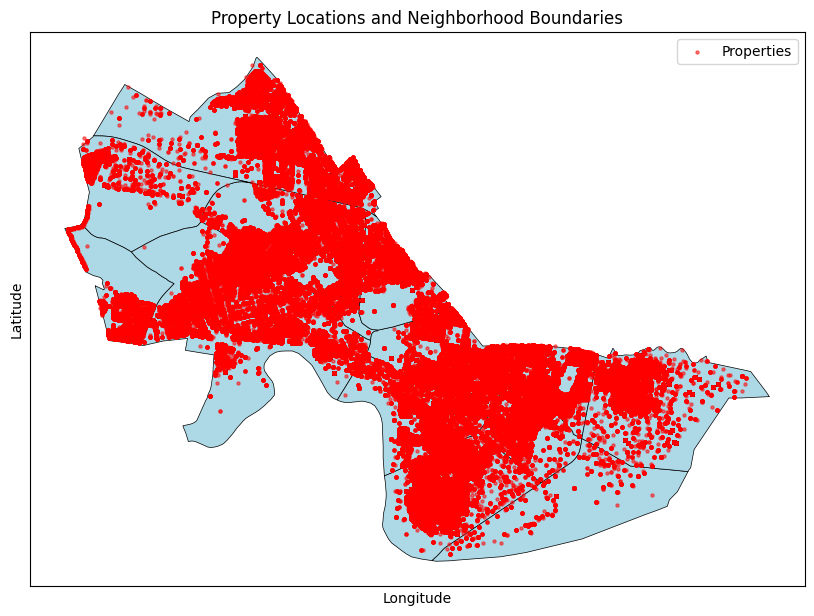

In [ ]:
# Set up the plot
fig1, ax1 = plt.subplots(figsize=(10, 10))

# Plot the neighborhood boundaries
neighborhoods.plot(ax=ax1, color='lightblue', edgecolor='black', linewidth=0.5)

# Plot the property points
# We use the original geometry of the gdf_assessment_items because joined_data's geometry might be altered
gdf_properties.plot(ax=ax1, markersize=5, color='red', alpha=0.5, label='Properties')

# Adding some plot decorations
ax1.set_title('Property Locations and Neighborhood Boundaries')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.legend()

# Remove the x and y axis for a cleaner look
ax1.set_xticks([])
ax1.set_yticks([])

plt.show()

In [ ]:
import matplotlib.colors as mcolors

# Use LogNorm for a logarithmic scale
properties = properties[properties['AssessedValue'] > 0]

# Set up the normalization using LogNorm
norm = mcolors.LogNorm(vmin=properties['AssessedValue'].min(), vmax=properties['AssessedValue'].max())
cmap = 'viridis'
# Loop through each year and plot the data
for year in range(2016, 2025):  # Modify as per your data range
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the neighborhood boundaries
    neighborhoods.plot(ax=ax, color='moccasin', edgecolor='black', linewidth=0.5)

    # Filter data for the current year
    year_data = gdf_properties[gdf_properties['YearOfAssessment'] == year]

    # Plot the property points, colored by assessed value
    year_data.plot(ax=ax, column='AssessedValue', cmap=cmap, markersize=5,
                   alpha=0.5, legend=True, norm=norm)

    # Customizing the plot
    ax.set_title(f'Property Values in {year}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

Output hidden; open in https://colab.research.google.com to view.